# Final step recognise!

In [1]:
%matplotlib inline

In [2]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import matplotlib.pyplot as plt

In [3]:
def display_image(image):
    im2 = image.copy()
    im2[:, :, 0] = image[:, :, 2]
    im2[:, :, 2] = image[:, :, 0]
    inputimg = plt.imshow(im2)

In [4]:
# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = os.path.sep.join(["face_detection_model", "deploy.prototxt"])
modelPath = os.path.sep.join(["face_detection_model",
                             "res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

[INFO] loading face detector...


In [5]:
# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch("openface_nn4.small2.v1.t7")

[INFO] loading face recognizer...


In [6]:
# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open("output/recognizer.pickle", "rb").read())
le = pickle.loads(open("output/le.pickle", "rb").read())

## Change input here

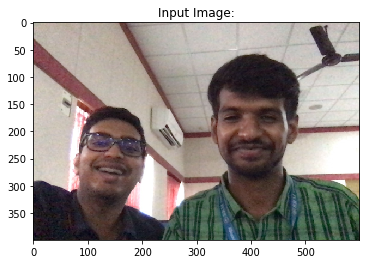

In [7]:
# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread("images/root3.jpg")
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
plt.title("Input Image:")
display_image(image)

In [8]:
# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)), 1.0, (300, 300),
    (104.0, 177.0, 123.0), swapRB=False, crop=False)

In [9]:
# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

In [10]:
# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the
    # prediction
    confidence = detections[0, 0, i, 2]

    # filter out weak detections
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for the
        # face
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # extract the face ROI
        face = image[startY:endY, startX:endX]
        (fH, fW) = face.shape[:2]

        # ensure the face width and height are sufficiently large
        if fW < 20 or fH < 20:
            continue

        # construct a blob for the face ROI, then pass the blob
        # through our face embedding model to obtain the 128-d
        # quantification of the face
        faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
                                         (0, 0, 0), swapRB=True, crop=False)
        embedder.setInput(faceBlob)
        vec = embedder.forward()

        # perform classification to recognize the face
        preds = recognizer.predict_proba(vec)[0]
        j = np.argmax(preds)
        proba = preds[j]
        name = le.classes_[j]

        # draw the bounding box of the face along with the associated
        # probability
        text = "{}: {:.2f}%".format(name, proba * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(image, (startX, startY), (endX, endY),
                      (0, 0, 255), 2)
        cv2.putText(image, text, (startX, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

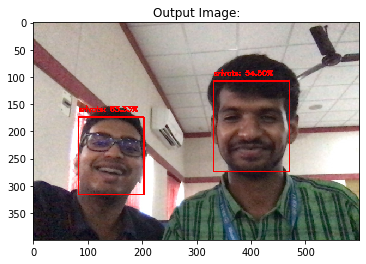

In [11]:
plt.title("Output Image:")
display_image(image)